## Table of Contents

### 1. Data Loading and Preprocessing 
> #### 1.1 Load the Data
> #### 1.2 Define custom dataset and dataloader
> #### 1.3 Data Exploration
### 2. Image Generation using simple GANs
> #### 2.1 Define model architecture
> #### 2.2 Train the model
> #### 2.3 Generate random images


---

### 1. Data Loading and Preprocessing

#### 1.1 Load the Data

In [1]:
# Upload data from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# get images
!unzip '/content/drive/MyDrive/images_dtd-200713-114828.zip'

Archive:  /content/drive/MyDrive/images_dtd-200713-114828.zip
  inflating: images_dtd/banded_0002.jpg  
  inflating: images_dtd/banded_0004.jpg  
  inflating: images_dtd/banded_0005.jpg  
  inflating: images_dtd/banded_0006.jpg  
  inflating: images_dtd/banded_0008.jpg  
  inflating: images_dtd/banded_0009.jpg  
  inflating: images_dtd/banded_0010.jpg  
  inflating: images_dtd/banded_0011.jpg  
  inflating: images_dtd/banded_0012.jpg  
  inflating: images_dtd/banded_0013.jpg  
  inflating: images_dtd/banded_0016.jpg  
  inflating: images_dtd/banded_0019.jpg  
  inflating: images_dtd/banded_0021.jpg  
  inflating: images_dtd/banded_0022.jpg  
  inflating: images_dtd/banded_0023.jpg  
  inflating: images_dtd/banded_0024.jpg  
  inflating: images_dtd/banded_0025.jpg  
  inflating: images_dtd/banded_0030.jpg  
  inflating: images_dtd/banded_0033.jpg  
  inflating: images_dtd/banded_0034.jpg  
  inflating: images_dtd/banded_0036.jpg  
  inflating: images_dtd/banded_0037.jpg  
  inflating: i

In [5]:
# print number of images in the dataset
!ls -l images_dtd | grep ".jpg" | wc -l

2500


In [2]:
# import libraries and modules
%matplotlib inline

import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

# import pytorch related modules
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Resize, RandomCrop, Grayscale, Normalize

from torch.optim import Adam

from torch.nn import Sequential
from torch.nn import Linear, LeakyReLU, BatchNorm1d, Sigmoid, Tanh, Flatten, BCELoss

In [3]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed);

In [7]:
images_dir = "/content/images_dtd"   # folder where all images are placed

#### 1.2 Define custom dataset and dataloader

1. In __init__ function, we define class variable having all image paths. Here only chequered images names are appended in list image_names (As we are giving simple problem to model).

 Now paths of all chequered images in this image_names list is stored in another list images_paths.

2. __getitem__ : This function is used to apply data augmentation. Transform function does following operations.

Grayscale(), # Converted selected image to grayscale

Resize(80), # Resize image to size 80X80

RandomCrop(64), # Randomly Crop this image of size 64X64

ToTensor(),     # Convert image to tensor

Normalize([0.5], [0.5])  # Normalize image to mean= SD=0.5 (To make images in range -1 to 1)
                    

                  
3. __len__ : This function is used to get length of list mentioned.

In [8]:
# define custom dataset class
class TextureDataset(Dataset):
    def __init__(self, images_dir):

        # get image names of images which are chequered
        self.image_names = []
        for image in os.listdir(images_dir):
            if image.split('_')[0] == "chequered":   # ie if we found string "chequered" in image name, append in list
                self.image_names.append(image)

        # get image paths for all "chequered" images.
        self.images_paths = []
        for image_name in self.image_names:
            self.images_paths.append(os.path.join(images_dir, image_name))
    
    def __getitem__(self, idx):
        
        # read data
        image = Image.open(self.images_paths[idx])

        # apply data augmentation
        transform = Compose([
                    Grayscale(),
                    Resize(80),
                    RandomCrop(64),
                    ToTensor(),
                    Normalize([0.5], [0.5])
                    ])
        
        image = transform(image)
        
        return image
        
    def __len__(self):
        return len(self.image_names)

In [12]:
# create instance of custom dataset
dataset = TextureDataset(images_dir)

# create dataloader
data_loader = DataLoader(
    dataset, 
    batch_size=16,
    num_workers=4,
    shuffle=True
)   
# Each bach will be of size 16 images

#### 1.3 Data Exploration

In [15]:
# check for one iteration of loop
for batch_x in data_loader:
    break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [16]:
# get shapes of batches
batch_x.shape

torch.Size([16, 1, 64, 64])

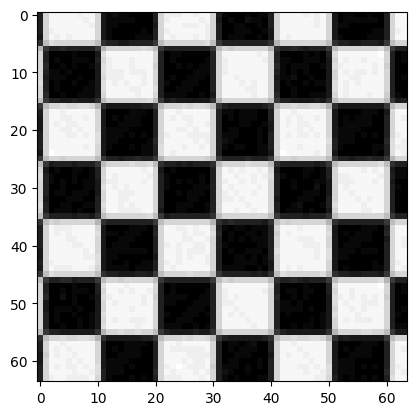

In [21]:
# print image
plt.imshow(batch_x[8].squeeze(), cmap='gray')

In [23]:
batch_x.min(), batch_x.max()
# min and max values of image in batch

(tensor(-1.), tensor(1.))

### 2. Image Generation using simple GANs

#### 2.1 Define model architecture

Define discriminator model architecture:

1. Input (image of size 64X64) ie 4096 input features to first hidden layer

2. Hidden layer 1: Dense(num_neurons=128, activation='leaky_relu')

3. Hidden layer 2: Dense(num_neurons=64, activation='leaky_relu')

4. Output layer for binary classification between original and generated image: Dense(num_neurons=1, activation='sigmoid')

In [24]:

discriminator = Sequential(
    Linear(64*64*1, 128),
    LeakyReLU(0.2),
    Linear(128, 64),
    LeakyReLU(0.2),
    Linear(64, 1),
    Sigmoid()
)

In [25]:
# print model
discriminator

Sequential(
  (0): Linear(in_features=4096, out_features=128, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=64, out_features=1, bias=True)
  (5): Sigmoid()
)

In [26]:
# check model on one image
output = discriminator(batch_x[:1].view(1, -1)).detach().numpy()

In [28]:
output  # probability o/p of sigmoid

array([[0.5103938]], dtype=float32)

Define generator model architecture:

It generates images of size 64X64 with values between -1 to 1.

1. Input with 100 features

2. Hidden layer 1: Dense(num_neurons=64, activation='leaky_relu')

3. Hidden layer 1: Dense(num_neurons=128, activation='leaky_relu')

4. output layer to create image of size 64X64: Dense(num_neurons=64*64, activation='tanh')

In [29]:

generator = Sequential(
    Linear(100, 64),
    LeakyReLU(0.2),
    Linear(64, 128),
    BatchNorm1d(128),
    LeakyReLU(0.2),
    Linear(128, 64*64*1),
    Tanh()
)

In [30]:
generator

Sequential(
  (0): Linear(in_features=100, out_features=64, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=64, out_features=128, bias=True)
  (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2)
  (5): Linear(in_features=128, out_features=4096, bias=True)
  (6): Tanh()
)

In [31]:
# check model on one image
generator.eval()
output = generator(torch.randn(1, 100)).detach().numpy()

In [32]:
output.shape

(1, 4096)

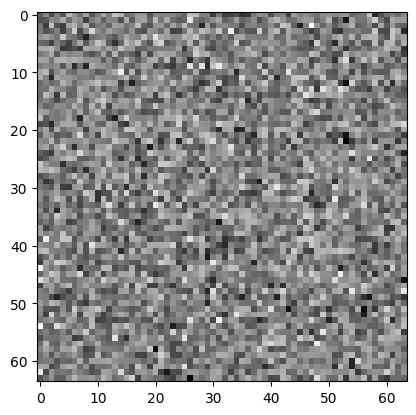

In [33]:
plt.imshow(output.reshape(64, 64), cmap='gray')

#### 2.2 Train the model

In [34]:
# Transfer models to GPU
discriminator = discriminator.to('cuda')
generator = generator.to('cuda')

In [35]:
# Initialize BCELoss function
criterion = BCELoss()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# fixed noise for plotting ie visualize training
fixed_noise = torch.randn(1, 100)

# number of epochs
num_epochs = 1000

# Setup Adam optimizers for both G and D
optimizerD = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
#num_epochs=1000

Training loss for epoch 20 is 0.81403 for disciminator and 1.26532 for generator
Training loss for epoch 40 is 0.50436 for disciminator and 2.20137 for generator
Training loss for epoch 60 is 0.56586 for disciminator and 2.41216 for generator
Training loss for epoch 80 is 0.61643 for disciminator and 1.91681 for generator
Training loss for epoch 100 is 0.65776 for disciminator and 1.78527 for generator

Generated Image


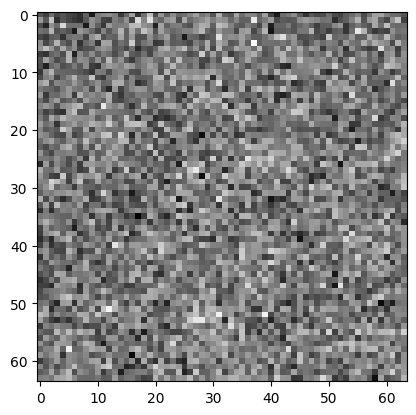

Training loss for epoch 120 is 0.68690 for disciminator and 1.77180 for generator
Training loss for epoch 140 is 0.70165 for disciminator and 1.86651 for generator
Training loss for epoch 160 is 0.80500 for disciminator and 1.86106 for generator
Training loss for epoch 180 is 0.64724 for disciminator and 1.84760 for generator
Training loss for epoch 200 is 0.75397 for disciminator and 1.74222 for generator

Generated Image


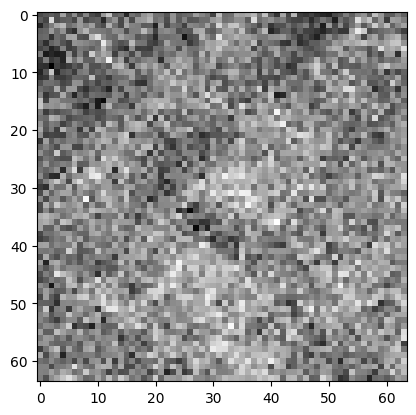

Training loss for epoch 220 is 0.75961 for disciminator and 1.83675 for generator
Training loss for epoch 240 is 0.99414 for disciminator and 1.98830 for generator
Training loss for epoch 260 is 0.71669 for disciminator and 1.98212 for generator
Training loss for epoch 280 is 0.77241 for disciminator and 1.92836 for generator
Training loss for epoch 300 is 0.89202 for disciminator and 2.15106 for generator

Generated Image


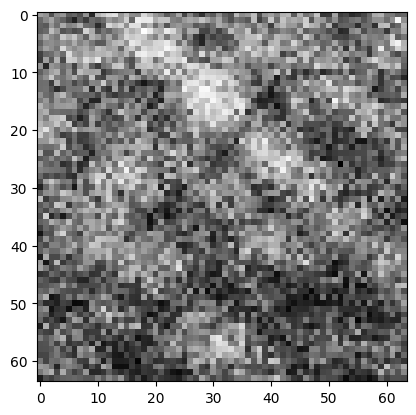

Training loss for epoch 320 is 0.74400 for disciminator and 2.08432 for generator
Training loss for epoch 340 is 0.89950 for disciminator and 1.71083 for generator
Training loss for epoch 360 is 0.71791 for disciminator and 1.82312 for generator
Training loss for epoch 380 is 0.83098 for disciminator and 1.70699 for generator
Training loss for epoch 400 is 0.88024 for disciminator and 1.74251 for generator

Generated Image


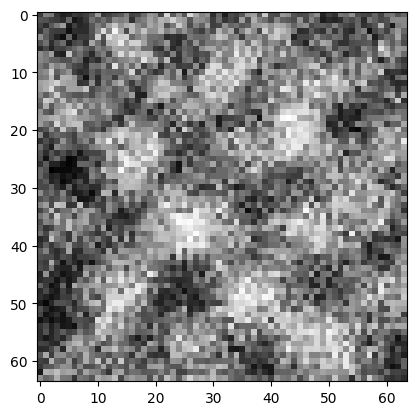

Training loss for epoch 420 is 0.87569 for disciminator and 1.79051 for generator
Training loss for epoch 440 is 0.93898 for disciminator and 1.79960 for generator
Training loss for epoch 460 is 0.95081 for disciminator and 1.69444 for generator
Training loss for epoch 480 is 0.79317 for disciminator and 1.75392 for generator
Training loss for epoch 500 is 1.14400 for disciminator and 1.71824 for generator

Generated Image


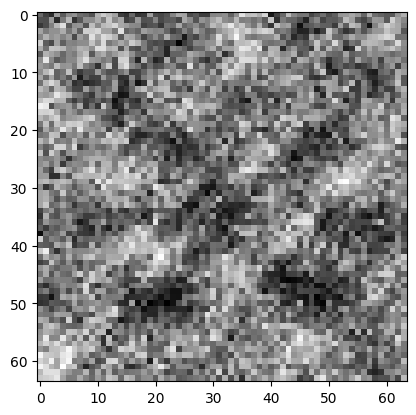

Training loss for epoch 520 is 0.90434 for disciminator and 1.68516 for generator
Training loss for epoch 540 is 0.88979 for disciminator and 1.62821 for generator
Training loss for epoch 560 is 0.81154 for disciminator and 1.83350 for generator
Training loss for epoch 580 is 0.87106 for disciminator and 1.72055 for generator
Training loss for epoch 600 is 1.01930 for disciminator and 1.78355 for generator

Generated Image


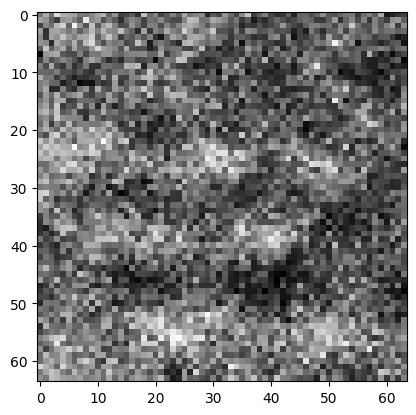

Training loss for epoch 620 is 1.00553 for disciminator and 1.68654 for generator
Training loss for epoch 640 is 0.94294 for disciminator and 1.61285 for generator
Training loss for epoch 660 is 0.92890 for disciminator and 1.58445 for generator
Training loss for epoch 680 is 0.93519 for disciminator and 1.71489 for generator
Training loss for epoch 700 is 0.99236 for disciminator and 1.58718 for generator

Generated Image


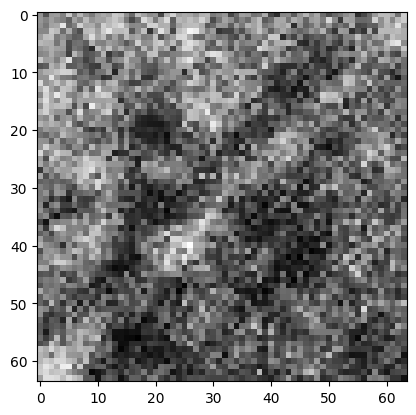

Training loss for epoch 720 is 0.79569 for disciminator and 1.70801 for generator
Training loss for epoch 740 is 0.96384 for disciminator and 1.62677 for generator
Training loss for epoch 760 is 0.95137 for disciminator and 1.68229 for generator
Training loss for epoch 780 is 0.95551 for disciminator and 1.63813 for generator
Training loss for epoch 800 is 0.92929 for disciminator and 1.55486 for generator

Generated Image


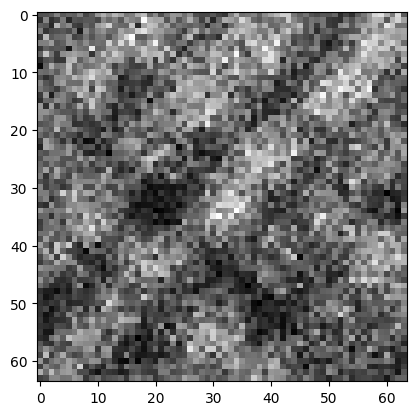

Training loss for epoch 820 is 0.97567 for disciminator and 1.59412 for generator
Training loss for epoch 840 is 0.96863 for disciminator and 1.55807 for generator
Training loss for epoch 860 is 1.08657 for disciminator and 1.51529 for generator
Training loss for epoch 880 is 0.96234 for disciminator and 1.63103 for generator
Training loss for epoch 900 is 0.95115 for disciminator and 1.52107 for generator

Generated Image


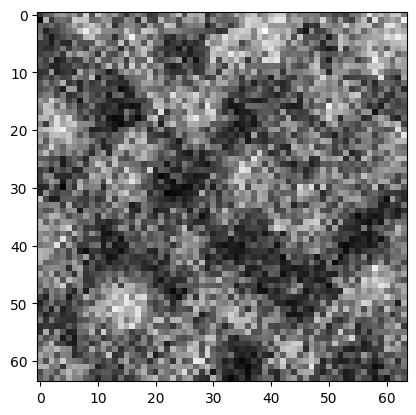

Training loss for epoch 920 is 0.89634 for disciminator and 1.49207 for generator
Training loss for epoch 940 is 0.91828 for disciminator and 1.63071 for generator
Training loss for epoch 960 is 0.89830 for disciminator and 1.50884 for generator
Training loss for epoch 980 is 0.87114 for disciminator and 1.52927 for generator
Training loss for epoch 1000 is 0.88377 for disciminator and 1.64864 for generator

Generated Image


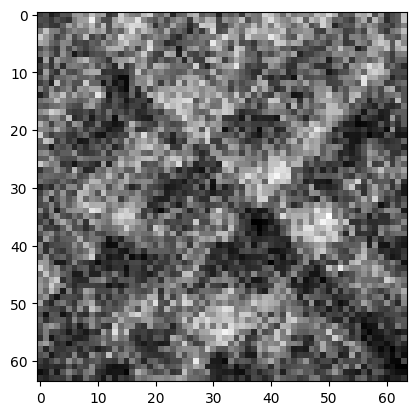

In [36]:
# set model to train
discriminator.train()
generator.train()

# train model
for epoch in range(num_epochs):

    # initialize variables epoch counts
    epochG_loss = epochD_loss = cnt = 0

    # loop through the data
    for i, batch_x in enumerate(data_loader):
        ## train discriminator

        # get real images and targets and transfer them to GPU
        batch_x = batch_x.to("cuda").float()
 
        batch_size = batch_x.shape[0] # take shape of batch to define batch y

        # batch y is for giving label, here it is giving real label to input images batch(1)
        batch_y = torch.full((batch_size,), real_label, device="cuda")

        # clear gradients
        discriminator.zero_grad()

        # pass real images to discriminator model
        outputs = discriminator(batch_x.view(batch_size, -1)).view(-1)

        # get loss between real labels and predicted for real images
        errD_real = criterion(outputs, batch_y.float())

        # do a backward pass
        errD_real.backward()

        # get fake images and targets and transfer them to GPU
        generated_images = generator(torch.randn(batch_size, 100, device="cuda"))
        # Label generated images as fake (0)
        batch_y = torch.full((batch_size,), fake_label, device="cuda")

        # pass fake images to discriminator model
        outputs = discriminator(generated_images.detach()).view(-1)

        # get loss between real labels and predicted for fake images
        errD_fake = criterion(outputs, batch_y.float())

        # do a backward pass
        errD_fake.backward()

        # update gradients
        optimizerD.step()

        ## train generator

        # clear gradients
        generator.zero_grad()

        # get real targets and transfer them to GPU
        batch_y = torch.full((batch_size,), real_label, device="cuda")

        # pass fake images to discriminator model
        outputs = discriminator(generated_images).view(-1)

        # get loss
        errG = criterion(outputs, batch_y.float())

        # do a backward pass
        errG.backward()

        # add loss 
        errD = errD_real + errD_fake

        # update gradients
        optimizerG.step()

        # sum loss and get count
        epochD_loss += errD.item()
        epochG_loss += errG.item()
        cnt += 1

    # take average loss for all batches
    epochD_loss /= cnt
    epochG_loss /= cnt
    
    # print loss after 20 epoch  and generate image after 100 epoch
    if (epoch + 1) % 20 == 0:
        print("Training loss for epoch {} is {:.5f} for disciminator and {:.5f} for generator".format(epoch + 1, epochD_loss, epochG_loss))
    if (epoch + 1) % 100 == 0:
        print('\nGenerated Image')
        
        # get prediction
        generator.eval()
        with torch.no_grad():
            output = generator(fixed_noise.to('cuda')).detach().cpu().numpy()

        # plot generated image 
        plt.imshow(output.reshape(64, 64), cmap='gray')
        plt.show()

        # revert back to training
        generator.train()

#### 2.3 Generate random images

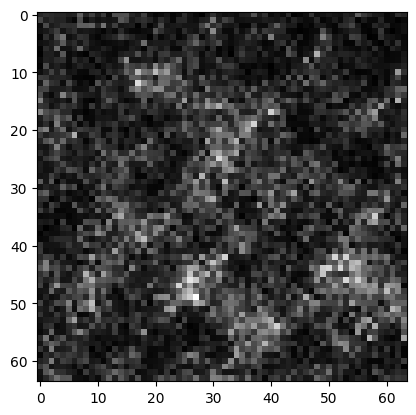

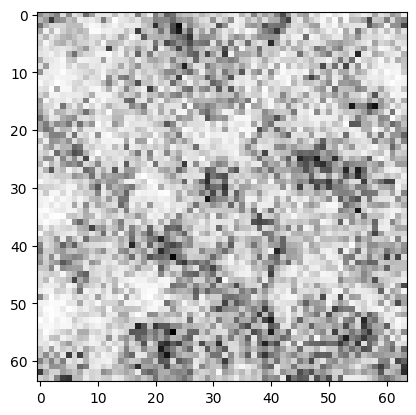

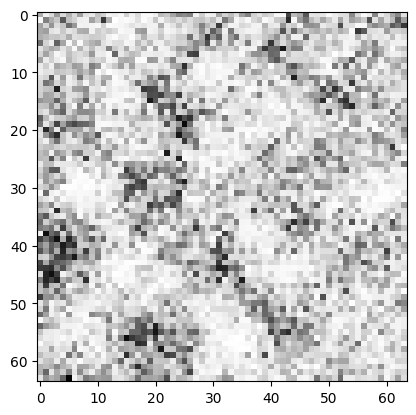

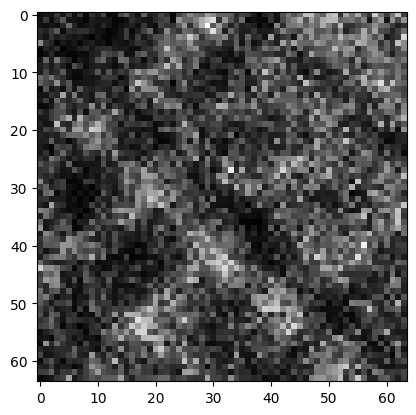

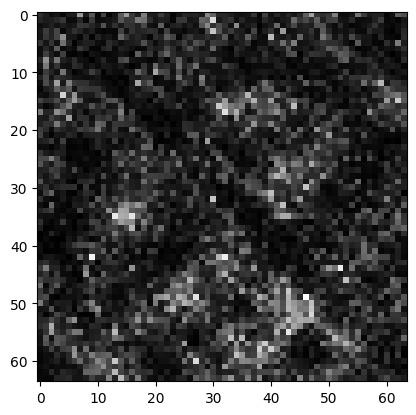

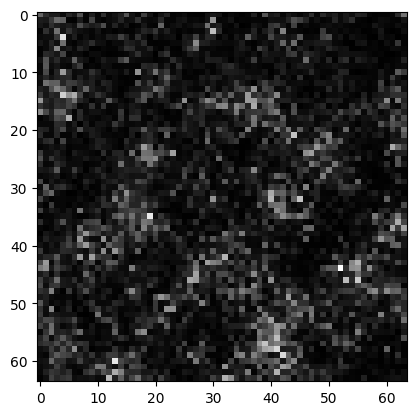

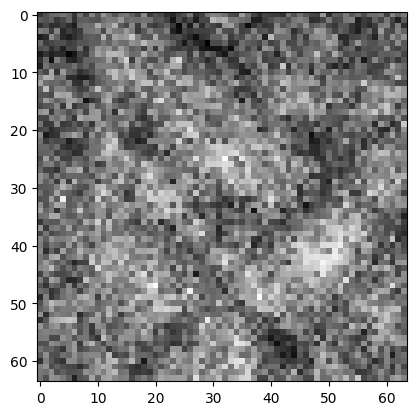

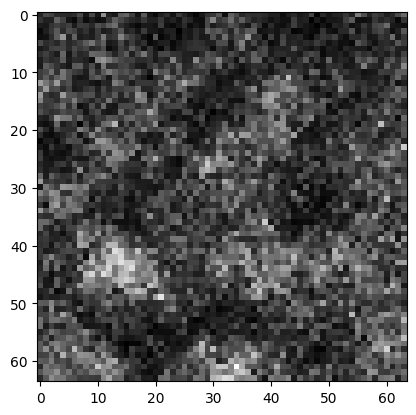

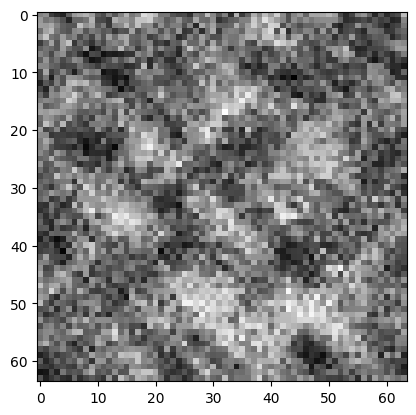

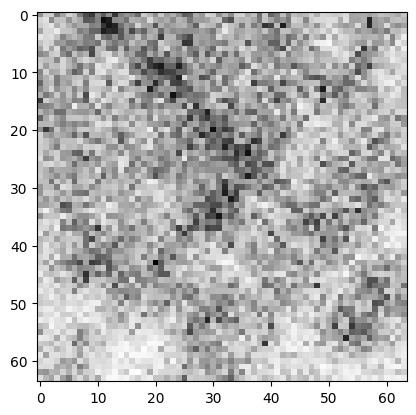

In [37]:
# generate ten random images
generator.eval()

generated_images = generator(torch.randn(10, 100).to('cuda')).detach().cpu().numpy()

for image in generated_images:
    plt.imshow(image.reshape(64, 64), cmap='gray')
    plt.show()

In [38]:
generated_images.min(), generated_images.mean(), generated_images.max()

(-0.99812245, -0.18465312, 0.9938092)